# Brent Oil Price Forecast with LSTM Model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.vis_utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.7.0
Num GPUs Available:  0


## Reading dataset

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(8868, 2)

Note the date gaps.

## Drop negative prices if any

In [3]:
indexNames = df[df['Price'] < 0].index
df.drop(indexNames , inplace=True)
df.shape

(8868, 2)

## Filling date gaps

For market closed dates, use the previous date's price.

In [4]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.shape

(12760, 2)

In [5]:
df.tail()

,Date,Price
Date,,
2022-04-21,2022-04-21,107.20
2022-04-22,2022-04-22,105.15
2022-04-23,2022-04-23,105.15
2022-04-24,2022-04-24,105.15
2022-04-25,2022-04-25,99.27


## Preparing the time series dataset

In [6]:
time_step = [i for i in range(df.shape[0])]
series = np.array(df[['Price']])
time = np.array(time_step)

## Functions

In [7]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Visualizing the time series dataset

Text(0.5, 1.0, 'Brent Oil Price')

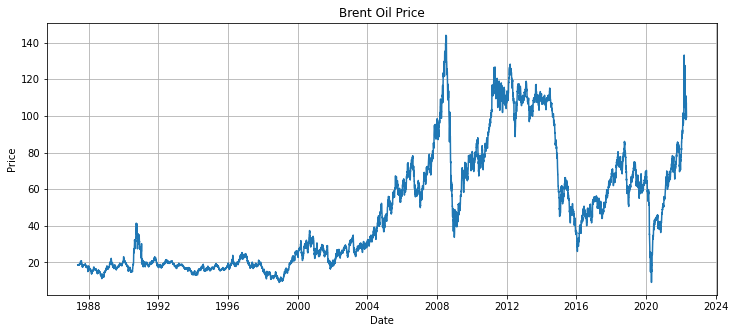

In [10]:
plt.figure(figsize=(12, 5))
plot_series(df['Date'], df['Price'])
plt.title('Brent Oil Price')

## Spliting the dataset for training and validation

In [11]:
split_time = 11500
time_train = time[:split_time]
x_train = series[:split_time]
x_label_train = df[['Date']][:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
x_label_valid = df[['Date']][split_time:]

## Hyperparameters

In [12]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
epochs = 500

## Tuning the learning rate

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                      strides = 1, padding = "causal",
                      activation = "relu",
                      input_shape = [None, 1]),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.Dense(30, activation = "relu"),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ["mae"])
history_tune = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(11500, 1)
Epoch 1/100
45/45 [==============================] - 7s 126ms/step - loss: 48.5430 - mae: 49.0429
Epoch 2/100
45/45 [==============================] - 5s 114ms/step - loss: 37.4642 - mae: 37.9603
Epoch 3/100
45/45 [==============================] - 5s 114ms/step - loss: 32.0064 - mae: 32.4913
Epoch 4/100
45/45 [==============================] - 5s 118ms/step - loss: 29.5851 - mae: 30.0707
Epoch 5/100
45/45 [==============================] - 5s 116ms/step - loss: 27.5611 - mae: 28.0454
Epoch 6/100
45/45 [==============================] - 5s 117ms/step - loss: 25.4049 - mae: 25.8867
Epoch 7/100
45/45 [==============================] - 5s 116ms/step - loss: 23.0225 - mae: 23.5016
Epoch 8/100
45/45 [==============================] - 5s 118ms/step - loss: 20.5401 - mae: 21.0160
Epoch 9/100
45/45 [==============================] - 5s 120ms/step - loss: 18.1595 - mae: 18.6313
Epoch 1

45/45 [==============================] - 6s 127ms/step - loss: 22.4397 - mae: 22.9339
Epoch 84/100
45/45 [==============================] - 6s 125ms/step - loss: 28.5622 - mae: 29.0593
Epoch 85/100
45/45 [==============================] - 6s 125ms/step - loss: 22.2256 - mae: 22.7214
Epoch 86/100
45/45 [==============================] - 6s 127ms/step - loss: 35.3908 - mae: 35.8890
Epoch 87/100
45/45 [==============================] - 6s 124ms/step - loss: 28.7637 - mae: 29.2621
Epoch 88/100
45/45 [==============================] - 6s 120ms/step - loss: 30.0262 - mae: 30.5238
Epoch 89/100
45/45 [==============================] - 6s 121ms/step - loss: 37.5013 - mae: 38.0001
Epoch 90/100
45/45 [==============================] - 6s 122ms/step - loss: 60.5150 - mae: 61.0140
Epoch 91/100
45/45 [==============================] - 6s 122ms/step - loss: 51.6911 - mae: 52.1893
Epoch 92/100
45/45 [==============================] - 6s 122ms/step - loss: 47.5969 - mae: 48.0952
Epoch 93/100
45/45 [===

In [14]:
min_loss = min(history_tune.history["loss"])
print(f'min_loss: {min_loss}')
index = np.argmin(history_tune.history["loss"])
learning_rate = history_tune.history["lr"][index]
print(f'learning_rate: {learning_rate}')

min_loss: 2.402961254119873
learning_rate: 3.5481339182297233e-06


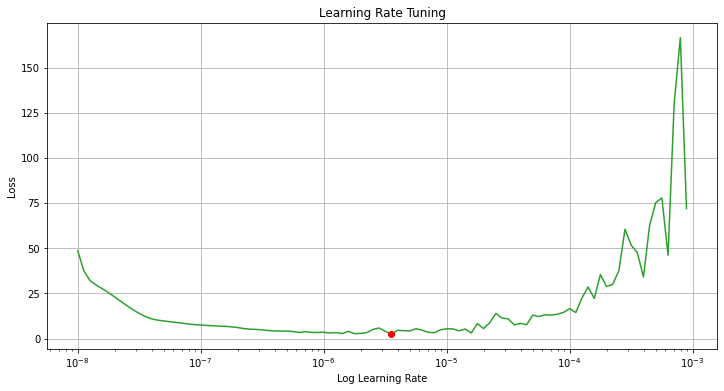

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history_tune.history['lr'], history_tune.history['loss'], color="C2")
plt.plot(learning_rate, min_loss, 'ro')    
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()

## Training the model

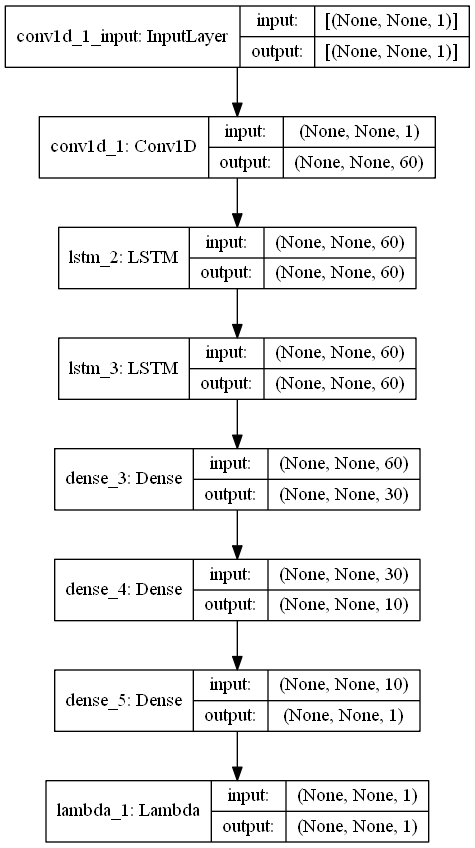

In [16]:
def build_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                          strides = 1, padding = "causal",
                          activation = "relu",
                          input_shape = [None, 1]),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.Dense(30, activation = "relu"),
      tf.keras.layers.Dense(10, activation = "relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
    model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])
    return model

model = build_model()
plot_model(model, to_file = 'lstm_model_plot.png', show_shapes = True, show_layer_names = True)

In [17]:
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
history_train = model.fit(train_set, epochs = epochs, validation_data = valid_set)

Epoch 1/500
45/45 [==============================] - 8s 139ms/step - loss: 17.9431 - mae: 18.4361 - val_loss: 5.6960 - val_mae: 6.1724
Epoch 2/500
45/45 [==============================] - 6s 133ms/step - loss: 4.7998 - mae: 5.2764 - val_loss: 3.9778 - val_mae: 4.4500
Epoch 3/500
45/45 [==============================] - 6s 138ms/step - loss: 4.2921 - mae: 4.7674 - val_loss: 3.8698 - val_mae: 4.3367
Epoch 4/500
45/45 [==============================] - 6s 134ms/step - loss: 4.8304 - mae: 5.2949 - val_loss: 6.2675 - val_mae: 6.7534
Epoch 5/500
45/45 [==============================] - 6s 132ms/step - loss: 7.4777 - mae: 7.9652 - val_loss: 3.7966 - val_mae: 4.2725
Epoch 6/500
45/45 [==============================] - 6s 130ms/step - loss: 3.9677 - mae: 4.4259 - val_loss: 6.7213 - val_mae: 7.2194
Epoch 7/500
45/45 [==============================] - 6s 137ms/step - loss: 2.3335 - mae: 2.7837 - val_loss: 2.2496 - val_mae: 2.6995
Epoch 8/500
45/45 [==============================] - 6s 137ms/step 

45/45 [==============================] - 6s 136ms/step - loss: 2.0631 - mae: 2.5252 - val_loss: 1.1623 - val_mae: 1.5778
Epoch 63/500
45/45 [==============================] - 6s 136ms/step - loss: 1.2328 - mae: 1.6812 - val_loss: 1.1375 - val_mae: 1.5637
Epoch 64/500
45/45 [==============================] - 6s 136ms/step - loss: 0.6314 - mae: 0.9732 - val_loss: 1.3676 - val_mae: 1.8092
Epoch 65/500
45/45 [==============================] - 6s 141ms/step - loss: 1.0677 - mae: 1.5060 - val_loss: 1.0711 - val_mae: 1.4887
Epoch 66/500
45/45 [==============================] - 7s 148ms/step - loss: 1.6252 - mae: 2.0930 - val_loss: 1.0063 - val_mae: 1.4112
Epoch 67/500
45/45 [==============================] - 7s 142ms/step - loss: 1.0866 - mae: 1.5202 - val_loss: 1.1365 - val_mae: 1.5522
Epoch 68/500
45/45 [==============================] - 6s 137ms/step - loss: 1.9947 - mae: 2.4613 - val_loss: 1.4248 - val_mae: 1.8696
Epoch 69/500
45/45 [==============================] - 6s 138ms/step - loss:

45/45 [==============================] - 6s 132ms/step - loss: 1.1856 - mae: 1.6263 - val_loss: 0.9258 - val_mae: 1.3222
Epoch 124/500
45/45 [==============================] - 6s 131ms/step - loss: 0.6659 - mae: 1.0590 - val_loss: 0.8982 - val_mae: 1.2960
Epoch 125/500
45/45 [==============================] - 6s 132ms/step - loss: 0.7096 - mae: 1.1134 - val_loss: 0.9318 - val_mae: 1.3327
Epoch 126/500
45/45 [==============================] - 6s 132ms/step - loss: 0.5897 - mae: 0.9667 - val_loss: 0.8273 - val_mae: 1.2002
Epoch 127/500
45/45 [==============================] - 6s 131ms/step - loss: 0.5304 - mae: 0.8735 - val_loss: 0.8708 - val_mae: 1.2661
Epoch 128/500
45/45 [==============================] - 6s 135ms/step - loss: 0.7962 - mae: 1.2161 - val_loss: 0.8655 - val_mae: 1.2464
Epoch 129/500
45/45 [==============================] - 6s 133ms/step - loss: 0.7532 - mae: 1.1485 - val_loss: 0.8730 - val_mae: 1.2607
Epoch 130/500
45/45 [==============================] - 6s 131ms/step 

Epoch 184/500
45/45 [==============================] - 6s 129ms/step - loss: 0.4895 - mae: 0.8480 - val_loss: 0.7663 - val_mae: 1.1331
Epoch 185/500
45/45 [==============================] - 6s 129ms/step - loss: 0.5194 - mae: 0.8898 - val_loss: 0.7652 - val_mae: 1.1322
Epoch 186/500
45/45 [==============================] - 6s 129ms/step - loss: 0.4553 - mae: 0.7740 - val_loss: 0.9376 - val_mae: 1.3572
Epoch 187/500
45/45 [==============================] - 6s 128ms/step - loss: 0.4526 - mae: 0.7711 - val_loss: 0.7893 - val_mae: 1.1663
Epoch 188/500
45/45 [==============================] - 6s 130ms/step - loss: 0.5719 - mae: 0.9582 - val_loss: 0.9865 - val_mae: 1.4182
Epoch 189/500
45/45 [==============================] - 6s 129ms/step - loss: 0.4805 - mae: 0.8207 - val_loss: 0.8931 - val_mae: 1.3047
Epoch 190/500
45/45 [==============================] - 6s 131ms/step - loss: 0.6612 - mae: 1.0713 - val_loss: 0.7657 - val_mae: 1.1351
Epoch 191/500
45/45 [==============================] - 

Epoch 245/500
45/45 [==============================] - 6s 130ms/step - loss: 0.4529 - mae: 0.7756 - val_loss: 0.7608 - val_mae: 1.1356
Epoch 246/500
45/45 [==============================] - 6s 129ms/step - loss: 0.4486 - mae: 0.7960 - val_loss: 0.8196 - val_mae: 1.2167
Epoch 247/500
45/45 [==============================] - 6s 131ms/step - loss: 0.5415 - mae: 0.9224 - val_loss: 0.7224 - val_mae: 1.0840
Epoch 248/500
45/45 [==============================] - 6s 130ms/step - loss: 0.4460 - mae: 0.7827 - val_loss: 0.8386 - val_mae: 1.2402
Epoch 249/500
45/45 [==============================] - 6s 131ms/step - loss: 0.4516 - mae: 0.7751 - val_loss: 0.8762 - val_mae: 1.2889
Epoch 250/500
45/45 [==============================] - 6s 130ms/step - loss: 0.6114 - mae: 1.0182 - val_loss: 0.8441 - val_mae: 1.2475
Epoch 251/500
45/45 [==============================] - 6s 130ms/step - loss: 0.5860 - mae: 0.9867 - val_loss: 0.8218 - val_mae: 1.2219
Epoch 252/500
45/45 [==============================] - 

Epoch 306/500
45/45 [==============================] - 6s 132ms/step - loss: 0.4157 - mae: 0.7261 - val_loss: 0.7126 - val_mae: 1.0725
Epoch 307/500
45/45 [==============================] - 6s 131ms/step - loss: 0.4623 - mae: 0.8060 - val_loss: 0.7017 - val_mae: 1.0538
Epoch 308/500
45/45 [==============================] - 6s 131ms/step - loss: 0.4409 - mae: 0.7916 - val_loss: 0.8225 - val_mae: 1.2271
Epoch 309/500
45/45 [==============================] - 6s 130ms/step - loss: 0.3948 - mae: 0.7252 - val_loss: 0.7257 - val_mae: 1.0952
Epoch 310/500
45/45 [==============================] - 6s 132ms/step - loss: 0.5174 - mae: 0.8846 - val_loss: 0.6966 - val_mae: 1.0501
Epoch 311/500
45/45 [==============================] - 6s 140ms/step - loss: 0.4529 - mae: 0.8056 - val_loss: 0.7881 - val_mae: 1.1753
Epoch 312/500
45/45 [==============================] - 6s 130ms/step - loss: 0.5195 - mae: 0.9096 - val_loss: 0.7693 - val_mae: 1.1559
Epoch 313/500
45/45 [==============================] - 

Epoch 367/500
45/45 [==============================] - 5s 120ms/step - loss: 0.4355 - mae: 0.7697 - val_loss: 0.6827 - val_mae: 1.0352
Epoch 368/500
45/45 [==============================] - 6s 121ms/step - loss: 0.4853 - mae: 0.8558 - val_loss: 0.7628 - val_mae: 1.1462
Epoch 369/500
45/45 [==============================] - 6s 123ms/step - loss: 0.4574 - mae: 0.8242 - val_loss: 0.6892 - val_mae: 1.0430
Epoch 370/500
45/45 [==============================] - 5s 121ms/step - loss: 0.3691 - mae: 0.6780 - val_loss: 0.7705 - val_mae: 1.1685
Epoch 371/500
45/45 [==============================] - 5s 120ms/step - loss: 0.4430 - mae: 0.8002 - val_loss: 0.7142 - val_mae: 1.0904
Epoch 372/500
45/45 [==============================] - 6s 121ms/step - loss: 0.4561 - mae: 0.8150 - val_loss: 0.6813 - val_mae: 1.0402
Epoch 373/500
45/45 [==============================] - 5s 121ms/step - loss: 0.4530 - mae: 0.8088 - val_loss: 0.8303 - val_mae: 1.2369
Epoch 374/500
45/45 [==============================] - 

Epoch 428/500
45/45 [==============================] - 6s 123ms/step - loss: 0.4257 - mae: 0.7664 - val_loss: 0.7061 - val_mae: 1.0721
Epoch 429/500
45/45 [==============================] - 6s 122ms/step - loss: 0.4063 - mae: 0.7464 - val_loss: 0.6619 - val_mae: 1.0076
Epoch 430/500
45/45 [==============================] - 6s 122ms/step - loss: 0.3785 - mae: 0.7007 - val_loss: 0.8051 - val_mae: 1.2178
Epoch 431/500
45/45 [==============================] - 6s 122ms/step - loss: 0.4264 - mae: 0.7676 - val_loss: 0.6664 - val_mae: 1.0147
Epoch 432/500
45/45 [==============================] - 6s 121ms/step - loss: 0.4087 - mae: 0.7503 - val_loss: 0.6587 - val_mae: 1.0042
Epoch 433/500
45/45 [==============================] - 6s 122ms/step - loss: 0.3994 - mae: 0.7399 - val_loss: 0.6478 - val_mae: 0.9964
Epoch 434/500
45/45 [==============================] - 6s 123ms/step - loss: 0.3450 - mae: 0.6329 - val_loss: 0.6848 - val_mae: 1.0433
Epoch 435/500
45/45 [==============================] - 

Epoch 489/500
45/45 [==============================] - 6s 123ms/step - loss: 0.4149 - mae: 0.7645 - val_loss: 0.6565 - val_mae: 1.0205
Epoch 490/500
45/45 [==============================] - 6s 123ms/step - loss: 0.3550 - mae: 0.6468 - val_loss: 0.6888 - val_mae: 1.0714
Epoch 491/500
45/45 [==============================] - 6s 121ms/step - loss: 0.3949 - mae: 0.7271 - val_loss: 0.7025 - val_mae: 1.0869
Epoch 492/500
45/45 [==============================] - 6s 122ms/step - loss: 0.4283 - mae: 0.7913 - val_loss: 0.6564 - val_mae: 1.0147
Epoch 493/500
45/45 [==============================] - 6s 122ms/step - loss: 0.4726 - mae: 0.8461 - val_loss: 0.6375 - val_mae: 0.9787
Epoch 494/500
45/45 [==============================] - 6s 124ms/step - loss: 0.3925 - mae: 0.7255 - val_loss: 0.6510 - val_mae: 0.9973
Epoch 495/500
45/45 [==============================] - 6s 124ms/step - loss: 0.3637 - mae: 0.6750 - val_loss: 0.8117 - val_mae: 1.2301
Epoch 496/500
45/45 [==============================] - 

## Forcasting

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Text(0.5, 1.0, 'Forcasting')

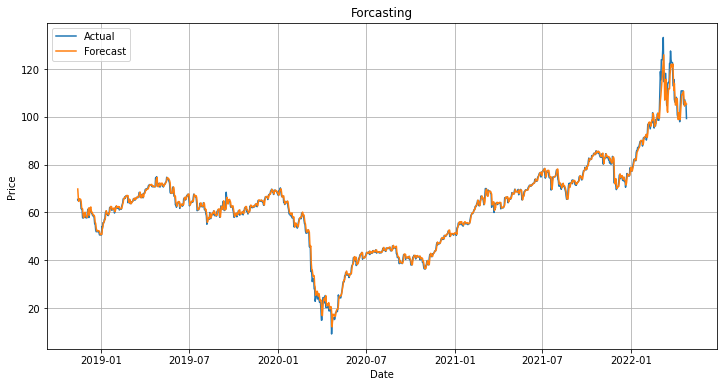

In [19]:
plt.figure(figsize=(12, 6))
plot_series(x_label_valid['Date'], x_valid)
plot_series(x_label_valid['Date'], rnn_forecast)
plt.legend(['Actual', 'Forecast'], loc = 'upper left')
plt.title('Forcasting')

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([13.645497, 13.583774, 13.666487, ..., 42.75479 , 42.75479 ,
       37.350727], dtype=float32)

In [21]:
zoom_begin = epochs - 50
zoon_end = epochs + 1
x_last = list(range(zoom_begin, zoon_end))

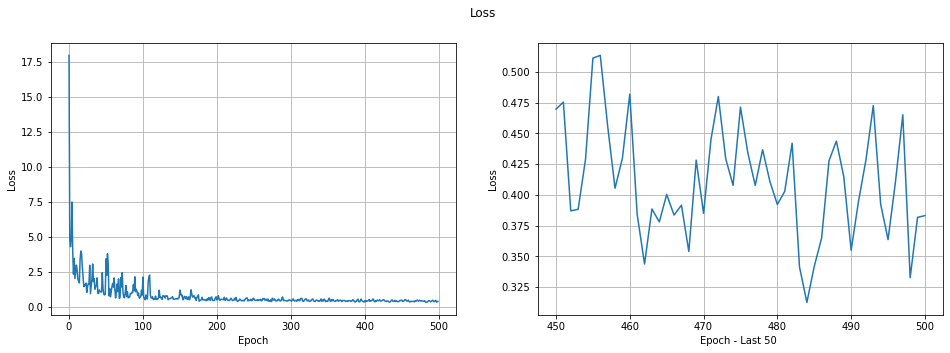

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Loss')
ax1.plot(range(0, epochs), history_train.history["loss"])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax2.plot(x_last, history_train.history["loss"][zoom_begin - 1:])
ax2.set_xlabel('Epoch - Last 50 ')
ax2.set_ylabel('Loss')
ax2.grid(True)

## Final training and saving

In [23]:
# The final model will be trained on the entire dataset
full_set = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
final_model = build_model()
history_final = final_model.fit(full_set, epochs = epochs)
final_model.save('lstm_model')

Epoch 1/500
50/50 [==============================] - 7s 110ms/step - loss: 22.4701 - mae: 22.9642
Epoch 2/500
50/50 [==============================] - 6s 119ms/step - loss: 8.4730 - mae: 8.9562
Epoch 3/500
50/50 [==============================] - 6s 122ms/step - loss: 6.2722 - mae: 6.7512
Epoch 4/500
50/50 [==============================] - 6s 122ms/step - loss: 4.2571 - mae: 4.7223
Epoch 5/500
50/50 [==============================] - 6s 122ms/step - loss: 4.3894 - mae: 4.8646
Epoch 6/500
50/50 [==============================] - 6s 122ms/step - loss: 4.6533 - mae: 5.1198
Epoch 7/500
50/50 [==============================] - 6s 122ms/step - loss: 6.7506 - mae: 7.2381
Epoch 8/500
50/50 [==============================] - 6s 122ms/step - loss: 5.0362 - mae: 5.5135
Epoch 9/500
50/50 [==============================] - 6s 124ms/step - loss: 3.8762 - mae: 4.3424
Epoch 10/500
50/50 [==============================] - 6s 123ms/step - loss: 2.8116 - mae: 3.2627
Epoch 11/500
50/50 [=================

50/50 [==============================] - 6s 122ms/step - loss: 2.0445 - mae: 2.5011
Epoch 86/500
50/50 [==============================] - 6s 120ms/step - loss: 1.9425 - mae: 2.3953
Epoch 87/500
50/50 [==============================] - 6s 122ms/step - loss: 2.1902 - mae: 2.6477
Epoch 88/500
50/50 [==============================] - 6s 120ms/step - loss: 1.8182 - mae: 2.2684
Epoch 89/500
50/50 [==============================] - 6s 121ms/step - loss: 0.7908 - mae: 1.1789
Epoch 90/500
50/50 [==============================] - 6s 120ms/step - loss: 0.7375 - mae: 1.1046
Epoch 91/500
50/50 [==============================] - 6s 121ms/step - loss: 0.7607 - mae: 1.1648
Epoch 92/500
50/50 [==============================] - 6s 120ms/step - loss: 0.6575 - mae: 1.0252
Epoch 93/500
50/50 [==============================] - 6s 122ms/step - loss: 0.6792 - mae: 1.0442
Epoch 94/500
50/50 [==============================] - 6s 120ms/step - loss: 0.8760 - mae: 1.2339
Epoch 95/500
50/50 [=======================

50/50 [==============================] - 6s 120ms/step - loss: 0.7029 - mae: 1.0828
Epoch 169/500
50/50 [==============================] - 6s 122ms/step - loss: 0.6731 - mae: 1.0525
Epoch 170/500
50/50 [==============================] - 6s 120ms/step - loss: 0.6412 - mae: 1.0355
Epoch 171/500
50/50 [==============================] - 6s 122ms/step - loss: 0.5279 - mae: 0.8823
Epoch 172/500
50/50 [==============================] - 6s 121ms/step - loss: 0.5314 - mae: 0.8867
Epoch 173/500
50/50 [==============================] - 6s 122ms/step - loss: 0.5234 - mae: 0.8800
Epoch 174/500
50/50 [==============================] - 6s 120ms/step - loss: 0.5381 - mae: 0.8919
Epoch 175/500
50/50 [==============================] - 6s 122ms/step - loss: 0.5554 - mae: 0.9057
Epoch 176/500
50/50 [==============================] - 6s 120ms/step - loss: 0.5088 - mae: 0.8571
Epoch 177/500
50/50 [==============================] - 6s 122ms/step - loss: 0.4969 - mae: 0.8347
Epoch 178/500
50/50 [=============

50/50 [==============================] - 676s 14s/step - loss: 0.4490 - mae: 0.7699
Epoch 252/500
50/50 [==============================] - 7s 134ms/step - loss: 0.3992 - mae: 0.7113
Epoch 253/500
50/50 [==============================] - 6s 122ms/step - loss: 0.4585 - mae: 0.7829
Epoch 254/500
50/50 [==============================] - 6s 122ms/step - loss: 0.4270 - mae: 0.7362
Epoch 255/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3984 - mae: 0.7033
Epoch 256/500
50/50 [==============================] - 6s 118ms/step - loss: 0.4684 - mae: 0.7988
Epoch 257/500
50/50 [==============================] - 6s 120ms/step - loss: 0.4494 - mae: 0.7721
Epoch 258/500
50/50 [==============================] - 6s 118ms/step - loss: 0.4452 - mae: 0.7765
Epoch 259/500
50/50 [==============================] - 6s 121ms/step - loss: 0.4922 - mae: 0.8194
Epoch 260/500
50/50 [==============================] - 6s 127ms/step - loss: 0.4293 - mae: 0.7420
Epoch 261/500
50/50 [=============

50/50 [==============================] - 7s 138ms/step - loss: 0.3968 - mae: 0.6917
Epoch 335/500
50/50 [==============================] - 7s 136ms/step - loss: 0.4216 - mae: 0.7333
Epoch 336/500
50/50 [==============================] - 7s 135ms/step - loss: 0.4260 - mae: 0.7430
Epoch 337/500
50/50 [==============================] - 7s 134ms/step - loss: 0.4245 - mae: 0.7492
Epoch 338/500
50/50 [==============================] - 7s 133ms/step - loss: 0.4414 - mae: 0.7777
Epoch 339/500
50/50 [==============================] - 7s 134ms/step - loss: 0.4256 - mae: 0.7390
Epoch 340/500
50/50 [==============================] - 7s 135ms/step - loss: 0.4048 - mae: 0.7070
Epoch 341/500
50/50 [==============================] - 7s 134ms/step - loss: 0.4733 - mae: 0.8020
Epoch 342/500
50/50 [==============================] - 7s 134ms/step - loss: 0.4774 - mae: 0.8080
Epoch 343/500
50/50 [==============================] - 7s 136ms/step - loss: 0.4375 - mae: 0.7747
Epoch 344/500
50/50 [=============

50/50 [==============================] - 7s 132ms/step - loss: 0.3915 - mae: 0.6977
Epoch 418/500
50/50 [==============================] - 7s 132ms/step - loss: 0.4222 - mae: 0.7539
Epoch 419/500
50/50 [==============================] - 7s 132ms/step - loss: 0.4240 - mae: 0.7489
Epoch 420/500
50/50 [==============================] - 7s 133ms/step - loss: 0.4193 - mae: 0.7460
Epoch 421/500
50/50 [==============================] - 7s 132ms/step - loss: 0.4123 - mae: 0.7349
Epoch 422/500
50/50 [==============================] - 7s 135ms/step - loss: 0.3957 - mae: 0.6950
Epoch 423/500
50/50 [==============================] - 7s 131ms/step - loss: 0.3962 - mae: 0.7029
Epoch 424/500
50/50 [==============================] - 7s 131ms/step - loss: 0.4022 - mae: 0.7167
Epoch 425/500
50/50 [==============================] - 7s 130ms/step - loss: 0.4347 - mae: 0.7734
Epoch 426/500
50/50 [==============================] - 7s 131ms/step - loss: 0.3984 - mae: 0.7058
Epoch 427/500
50/50 [=============

50/50 [==============================] - 7s 132ms/step - loss: 0.4918 - mae: 0.8576


INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets
